In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../iclr_17_compression/")
sys.path.append("../JIN_SRNet/JIN_SRNet/")
from precover_processing import read_pgm
from model import ImageCompressorSteganography, load_model
from test_model import plot_tensor 
import torch
import numpy as np
from torchvision import transforms

#### Approach #1 Saving compressed features on disk (torch.save or np.save)

/home/lucas/.conda/envs/research_project/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


feature shape torch.Size([1, 128, 32, 32])


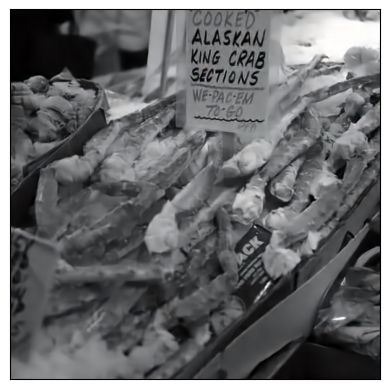

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


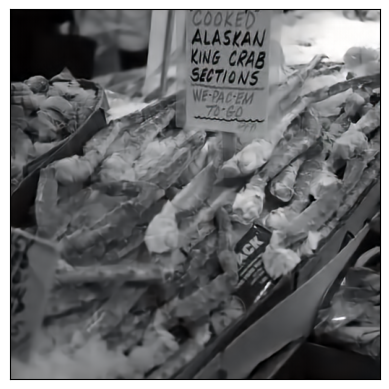

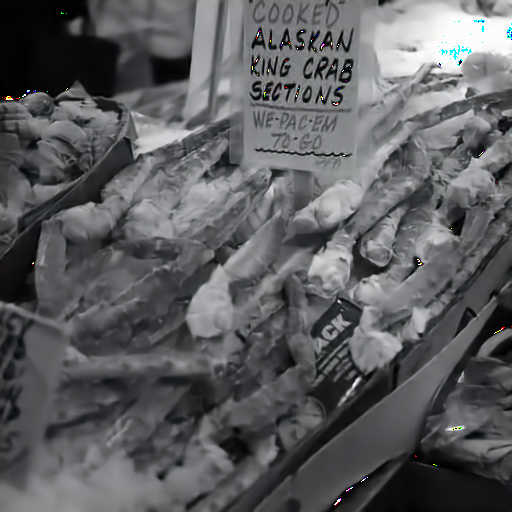

In [3]:
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()

with torch.no_grad():
    model = ImageCompressorSteganography()
    load_model(model,"../iclr_17_compression/checkpoints/baseline/iter_1590000.pth.tar")
    net = model.cuda()
    net.eval()
    
    precover = read_pgm("../JIN_SRNet/BossBase-1.01-precover/10000.pgm")
    precover_t = to_tensor(precover).repeat(1,3,1,1).cuda()

    # usual method to plot compressed image
    cover_t_usual, _, _ = net(precover_t)
    plot_tensor(cover_t_usual)

    # using the decoder of the model on saved tensor
    decoder = net.Decoder
    features_np = np.load("./img_saving/10000.npy")
    features_t = torch.from_numpy(features_np).cuda()
    cover_t_loaded = decoder(features_t)
    plot_tensor(cover_t_loaded)

to_pil(cover_t_loaded[0])


Some anomalies appears on the image plotted using the features saved on disk. There might be precision errors when saving compressed features on disk. The error is not visible on matplotlib's plot but it appears clearly with PIL.

#### Approach #2: save compressed images tensors on disk

feature shape torch.Size([1, 128, 32, 32])


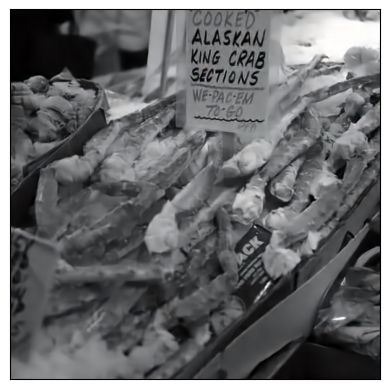

loaded_tensor == original_tensor True


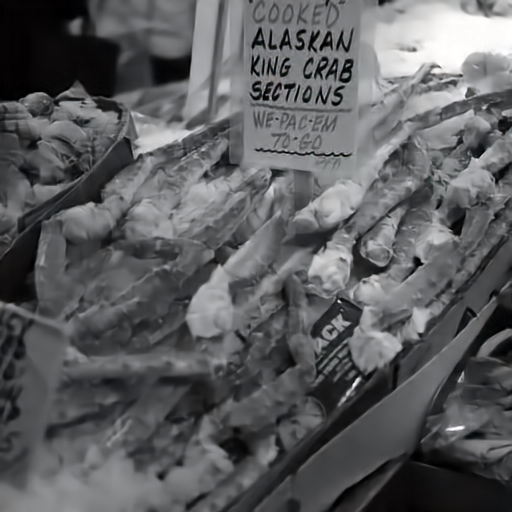

In [4]:
with torch.no_grad():
    model = ImageCompressorSteganography()
    load_model(model,"../iclr_17_compression/checkpoints/baseline/iter_1590000.pth.tar")
    net = model.cuda()
    net.eval()

    precover = read_pgm("../JIN_SRNet/BossBase-1.01-precover/10000.pgm")
    precover_t = to_tensor(precover).repeat(1,3,1,1).cuda()

    cover_t, _, _ = net(precover_t)
    plot_tensor(cover_t)

    torch.save(cover_t,"./img_saving/cover_t.pt")
    cover_t_loaded = torch.load("./img_saving/cover_t.pt")
    print("loaded_tensor == original_tensor",torch.equal(cover_t,cover_t_loaded))
to_pil(cover_t_loaded[0])

Here we obtain what we wanted, the anomalies are gone.